# Spatially correlated stochastic noise #

To make ocean currents based perturbations, 
it better to adapte randomness which contains spatial correlation information of ocean. </br>
To do this, in this notebook, try to make a **stochastic noise with Gaussian filtering** for spatial correlation. </br>
Furthermore, **information on ocean dynamics** derived from climatological anomalies is being introduced into the noise.

# Define spectral correlation function #

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def white_noise_to_correlated(shape, correlation_length, amplitude=1.0, seed=None):
    """
    Convert white noise to spatially correlated noise using Gaussian filtering.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output noise field (ny, nx) or (ny, nx, nt) for time series
    correlation_length : float
        Correlation length scale in grid points (controls spatial smoothness)
    amplitude : float
        Standard deviation of the output noise field
    seed : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    correlated_noise : ndarray
        Spatially correlated noise field
    """
    from scipy.ndimage import gaussian_filter
    
    # Generate white noise
    if seed is not None:
        rng = np.random.RandomState(seed)
        white_noise = rng.randn(*shape)
    else:
        white_noise = np.random.randn(*shape)
    
    # Apply Gaussian filter to create spatial correlations
    # sigma = correlation_length / (2 * sqrt(2 * ln(2))) for FWHM definition
    # But commonly we just use correlation_length directly as sigma
    sigma = correlation_length
    
    if len(shape) == 2:
        # 2D spatial field
        correlated_noise = gaussian_filter(white_noise, sigma=sigma)
    elif len(shape) == 3:
        # 3D field (2D space + time), apply spatial filtering only
        correlated_noise = gaussian_filter(white_noise, sigma=[sigma, sigma, 0])
    
    # Normalize to desired amplitude
    correlated_noise = correlated_noise / np.std(correlated_noise) * amplitude
    
    return correlated_noise


def spectral_correlated_noise(shape, correlation_length, amplitude=1.0, spectral_slope=-3, seed=None):
    """
    Generate spatially correlated noise using spectral method (more physical for ocean/eddies).
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output noise field (ny, nx)
    correlation_length : float
        Correlation length scale in grid points
    amplitude : float
        Standard deviation of the output noise field
    spectral_slope : float
        Spectral slope (default -3 for turbulent flow, -5/3 for inertial range)
    seed : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    correlated_noise : ndarray
        Spatially correlated noise field with realistic spectral characteristics
    """
    ny, nx = shape[:2]
    
    # Create frequency grid
    kx = np.fft.fftfreq(nx, d=1.0)
    ky = np.fft.fftfreq(ny, d=1.0)
    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX**2 + KY**2)
    K[0, 0] = 1.0  # Avoid division by zero
    
    # Generate white noise in spectral space
    if seed is not None:
        rng = np.random.RandomState(seed)
        white_spectrum = np.fft.fft2(rng.randn(ny, nx))
    else:
        white_spectrum = np.fft.fft2(np.random.randn(ny, nx))
    
    # Apply power law spectrum filter
    # E(k) ~ k^spectral_slope with exponential cutoff at correlation scale
    k0 = 1.0 / correlation_length
    spectral_filter = K**spectral_slope * np.exp(-K / k0)
    spectral_filter[0, 0] = 0  # Remove mean
    
    # Apply filter in spectral space
    filtered_spectrum = white_spectrum * spectral_filter
    
    # Transform back to physical space
    correlated_noise = np.real(np.fft.ifft2(filtered_spectrum))
    
    # Normalize to desired amplitude
    correlated_noise = correlated_noise / np.std(correlated_noise) * amplitude
    
    # Make noise positive and map to [0, 1]
    correlated_noise_positive = np.exp(correlated_noise)
    adjust_factor = (4+ spectral_slope) + 1e-6  # Prevent division by zero
    correlated_noise_positive_normalized = correlated_noise_positive / adjust_factor # / correlated_noise_positive.mean()
    
    return correlated_noise_positive_normalized

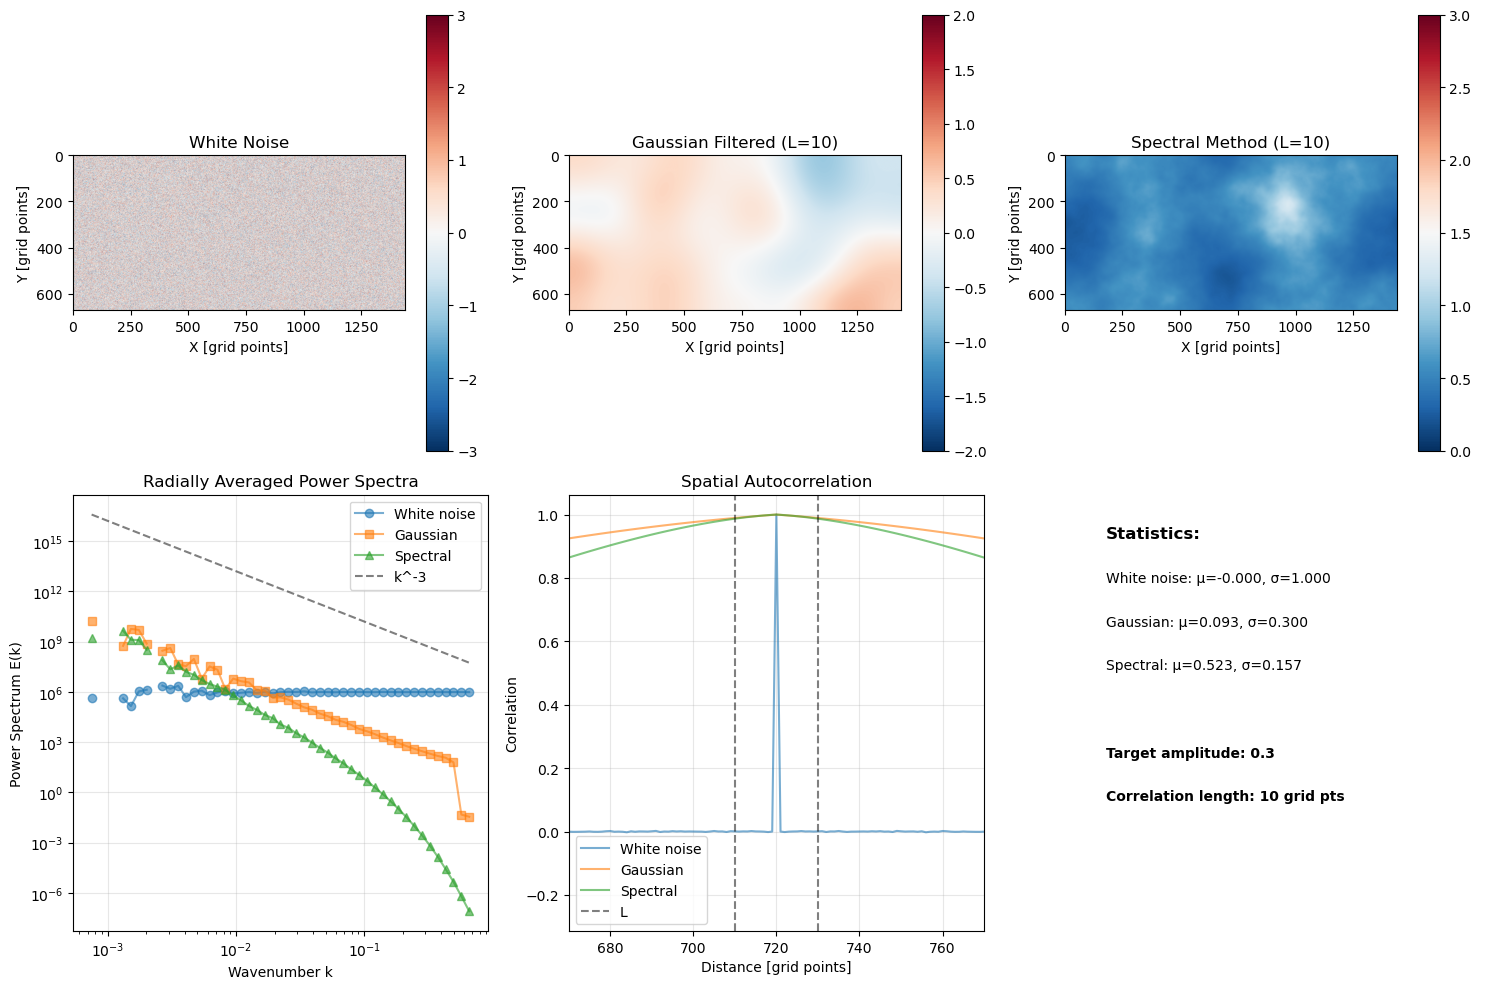

✓ Generated spatially correlated noise for ocean perturbations
  - Gaussian method: smooth filtering
  - Spectral method: realistic turbulent characteristics (recommended for eddies)


In [8]:

# Example usage and visualization
nx, ny = 1440, 672
correlation_length = 10  # grid points
amplitude = 0.3

# Method 1: Gaussian filtering
noise_gaussian = white_noise_to_correlated((ny, nx), 130, amplitude)

# Method 2: Spectral method (better for ocean dynamics)
noise_spectral = spectral_correlated_noise((ny, nx), correlation_length, amplitude, spectral_slope=-2, seed=44)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# White noise for comparison
white = np.random.randn(ny, nx)

# Plot noise fields
im0 = axes[0, 0].imshow(white, cmap='RdBu_r', vmin=-3, vmax=3)
axes[0, 0].set_title('White Noise')
axes[0, 0].set_xlabel('X [grid points]')
axes[0, 0].set_ylabel('Y [grid points]')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(noise_gaussian, cmap='RdBu_r', vmin=-2, vmax=2)
axes[0, 1].set_title(f'Gaussian Filtered (L={correlation_length})')
axes[0, 1].set_xlabel('X [grid points]')
axes[0, 1].set_ylabel('Y [grid points]')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(noise_spectral, cmap='RdBu_r', vmin=0, vmax=3)
axes[0, 2].set_title(f'Spectral Method (L={correlation_length})')
axes[0, 2].set_xlabel('X [grid points]')
axes[0, 2].set_ylabel('Y [grid points]')
plt.colorbar(im2, ax=axes[0, 2])

# Compute and plot 2D power spectra
def power_spectrum_2d(field):
    fft = np.fft.fft2(field)
    power = np.abs(fft)**2
    ny, nx = field.shape
    kx = np.fft.fftfreq(nx)
    ky = np.fft.fftfreq(ny)
    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX**2 + KY**2)
    return K, power

# Radially averaged spectra
def radial_spectrum(field, nbins=50):
    K, power = power_spectrum_2d(field)
    k_flat = K.flatten()
    power_flat = power.flatten()
    
    k_bins = np.logspace(np.log10(k_flat[k_flat>0].min()), 
                         np.log10(k_flat.max()), nbins)
    k_centers = (k_bins[:-1] + k_bins[1:]) / 2
    
    power_binned = []
    for i in range(len(k_bins)-1):
        mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
        if mask.sum() > 0:
            power_binned.append(power_flat[mask].mean())
        else:
            power_binned.append(np.nan)
    
    return k_centers, np.array(power_binned)

k1, p1 = radial_spectrum(white)
k2, p2 = radial_spectrum(noise_gaussian)
k3, p3 = radial_spectrum(noise_spectral)

axes[1, 0].loglog(k1, p1, 'o-', alpha=0.6, label='White noise')
axes[1, 0].loglog(k2, p2, 's-', alpha=0.6, label='Gaussian')
axes[1, 0].loglog(k3, p3, '^-', alpha=0.6, label='Spectral')
axes[1, 0].plot(k3, k3**-3 * p3[len(p3)//4], 'k--', alpha=0.5, label='k^-3')
axes[1, 0].set_xlabel('Wavenumber k')
axes[1, 0].set_ylabel('Power Spectrum E(k)')
axes[1, 0].set_title('Radially Averaged Power Spectra')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Compute spatial correlation functions
def spatial_correlation(field):
    from scipy.signal import correlate
    ny, nx = field.shape
    field_normalized = (field - field.mean()) / field.std()
    corr = correlate(field_normalized, field_normalized, mode='same', method='fft')
    corr = corr / corr.max()
    return corr

corr_white = spatial_correlation(white)
corr_gaussian = spatial_correlation(noise_gaussian)
corr_spectral = spatial_correlation(noise_spectral)

# Plot 1D slices through center
center_y = ny // 2
axes[1, 1].plot(corr_white[center_y, :], alpha=0.6, label='White noise')
axes[1, 1].plot(corr_gaussian[center_y, :], alpha=0.6, label='Gaussian')
axes[1, 1].plot(corr_spectral[center_y, :], alpha=0.6, label='Spectral')
axes[1, 1].axvline(nx//2 + correlation_length, color='k', linestyle='--', alpha=0.5, label='L')
axes[1, 1].axvline(nx//2 - correlation_length, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Distance [grid points]')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].set_title('Spatial Autocorrelation')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([nx//2 - 50, nx//2 + 50])

# Statistics comparison
axes[1, 2].text(0.1, 0.9, 'Statistics:', fontsize=12, fontweight='bold', transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.8, f'White noise: μ={white.mean():.3f}, σ={white.std():.3f}', 
                transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.7, f'Gaussian: μ={noise_gaussian.mean():.3f}, σ={noise_gaussian.std():.3f}', 
                transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.6, f'Spectral: μ={noise_spectral.mean():.3f}, σ={noise_spectral.std():.3f}', 
                transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.4, f'Target amplitude: {amplitude}', 
                transform=axes[1, 2].transAxes, fontweight='bold')
axes[1, 2].text(0.1, 0.3, f'Correlation length: {correlation_length} grid pts', 
                transform=axes[1, 2].transAxes, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Generated spatially correlated noise for ocean perturbations")
print(f"  - Gaussian method: smooth filtering")
print(f"  - Spectral method: realistic turbulent characteristics (recommended for eddies)")


In [7]:
noise_spectral.max()


np.float64(1.276008716156618)